<a href="https://colab.research.google.com/github/waqas-manzoor5595/Machine_learning_projects-b-/blob/main/KNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Data Preparation

We will be apply the kNN algorithm on a case study where we're trying to determine whether we should accept an individual's application for a credit card based on the individual's profile and credit history.

**Note for Jupyter Notebook**: All the libraries/packages need to be updated to the latest version for the code to execute without any errors. Kindly check whether the **scikit-learn** library has been updated to the newest version, 1.1.

We start with package imports and data preparation steps

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


In [ ]:
##Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
credit_df = pd.read_csv("MyCreditData.csv")
credit_df.head()

,checking_account,duration,credit_history,purpose,amount,savings_account,employment_duration,installment_rate,other_debtors,present_residence,...,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,gender,profit
0,3,18,0,2,1049,4,2,2,2,3,...,21,1,0,0,1,0,0,0,female,242
1,3,9,0,5,2799,4,0,1,2,0,...,36,1,0,1,1,1,0,0,male,596
2,0,12,4,8,841,0,1,1,2,3,...,23,1,0,0,3,0,0,0,female,25
3,3,12,0,5,2122,4,0,0,2,0,...,39,1,0,1,3,1,0,1,male,568
4,3,12,0,5,2171,4,0,2,2,3,...,38,0,2,1,3,0,0,1,male,782


In [ ]:
# ensure Python reads the categorical variables as categorical
non_categorical_columns = ['duration', 'amount', 'age', 'profit']
for column in credit_df.columns:
    if column not in non_categorical_columns:
        credit_df[column] = pd.Categorical(credit_df[column])

# Create binary dependent variable
credit_df["is_profitable"] = np.where(credit_df['profit'] > 0, 1, 0)

We do our usual 70/30 train test split:

In [ ]:
y = credit_df['is_profitable']
X = credit_df.iloc[:, :-2] # All columns but the last two, profit and is_profitable

# Use dummy variables for categorical variables
X = pd.get_dummies(X, drop_first=False)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 1)

# Standardize our non-dummy variables
scaler = StandardScaler()
X_train[['duration', 'amount', 'age']]= scaler.fit_transform(X_train[['duration', 'amount', 'age']])
X_val[['duration', 'amount', 'age']]= scaler.transform(X_val[['duration', 'amount', 'age']])

# Part 2 - Fitting a kNN Model

As before, our goal is to predict *is_profitable* using all available useful information, now using the k-Nearest Neighbors model (kNN).

We use grid search to determine optimal value of $k$.



## 2.1a Fitting kNN for Classificaiton using the validation data

The maximum accuracy is obtained at k = 14


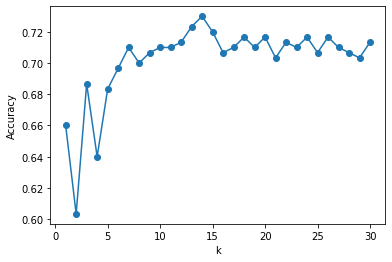

In [ ]:
kvalues = np.arange(1,31) # Parameter range

val_acc=[]

for k in kvalues:
  knn_clf = KNeighborsClassifier(n_neighbors=k)
  knn_clf.fit(X_train, y_train)
  y_pred = knn_clf.predict(X_val)
  val_acc.append(accuracy_score(y_val, y_pred))

### Accuracy vs k
plt.plot(kvalues,val_acc,marker='o')
plt.xlabel("k")
plt.ylabel("Accuracy")
print("The maximum accuracy is obtained at k = " + str(np.argmax(val_acc)+1))


Let's fit the best model and calculate some classification performance measures

In [ ]:
knn_clf_best = KNeighborsClassifier(n_neighbors=14)
knn_clf_best.fit(X_train, y_train)
y_pred = knn_clf_best.predict(X_val)

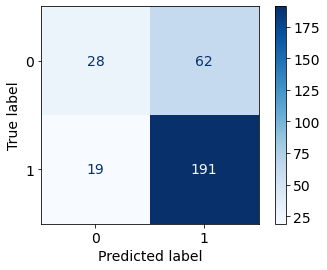

In [ ]:
plt.rcParams.update({'font.size': 14}) # To make the plot labels easier to read
ConfusionMatrixDisplay.from_estimator(
        knn_clf_best,
        X_val,
        y_val,
        cmap=plt.cm.Blues,
    )

In [ ]:
print('Validation data Accuracy Score: %.3f' % accuracy_score(y_val, y_pred))
print('Validation data F1 Score: %.3f' % f1_score(y_val, y_pred))
print('Validation data Sensitivity (recall of positive class): %.3f' % recall_score(y_val, y_pred, pos_label=1))
print('Validation data Specificty (recall of negative class): %.3f' % recall_score(y_val, y_pred, pos_label=0))

Validation data Accuracy Score: 0.730
Validation data F1 Score: 0.825
Validation data Sensitivity (recall of positive class): 0.910
Validation data Specificty (recall of negative class): 0.311


## 2.1b Fitting kNN for Classification using cross-validaiton

In [ ]:
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1,31)} # Parameter range

# defining parameter range
grid = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid_search = grid.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'n_neighbors': 12}

You can visualize the average validation accuracies obtained during the cross validation performed in the above step.

The maximum accuracy is obtained at k = 16
The maximum accuracy is obtained at k = {'n_neighbors': 16}


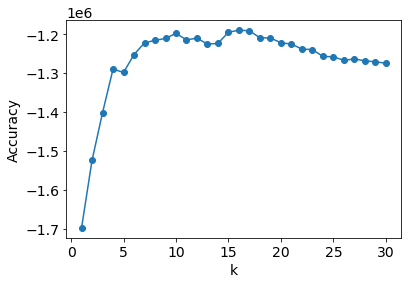

In [ ]:
### Accuracy vs k
plt.plot(param_grid['n_neighbors'], grid_search.cv_results_['mean_test_score'],marker='o')
plt.xlabel("k")
plt.ylabel("Accuracy")
print("The maximum accuracy is obtained at k = " + str(np.argmax(grid_search.cv_results_['mean_test_score'])+1))


And we find the performance of this model on the validation data:

In [ ]:
knn_clf_best = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_clf_best.fit(X_train, y_train)
y_pred = knn_clf_best.predict(X_val)

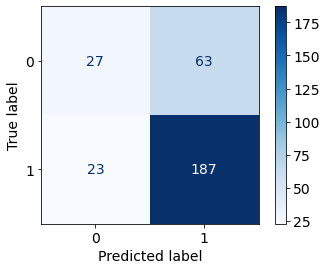

In [ ]:
plt.rcParams.update({'font.size': 14}) # To make the plot labels easier to read
ConfusionMatrixDisplay.from_estimator(
        knn_clf_best,
        X_val,
        y_val,
        cmap=plt.cm.Blues,
    )

In [ ]:
print('Validation data Accuracy Score: %.3f' % accuracy_score(y_val, y_pred))
print('Validation data F1 Score: %.3f' % f1_score(y_val, y_pred))
print('Validation data Sensitivity (recall of positive class): %.3f' % recall_score(y_val, y_pred, pos_label=1))
print('Validation data Specificty (recall of negative class): %.3f' % recall_score(y_val, y_pred, pos_label=0))

Validation data Accuracy Score: 0.713
Validation data F1 Score: 0.813
Validation data Sensitivity (recall of positive class): 0.890
Validation data Specificty (recall of negative class): 0.300


## 2.2 Fitting kNN for Prediction

Let's implement a prediction with KNN. We first re-establish y_val as a continuous variable:

In [ ]:
y = credit_df['profit']
y_train, y_val = train_test_split(y, test_size=0.3, random_state = 1)

And define our rmse function

In [ ]:
#rmse function
def rmse(y_train, y_pred):
  return np.sqrt(mean_squared_error(y_train, y_pred))

First lets use the validation data to select the best k

The minimum rmse is obtained at k = 29


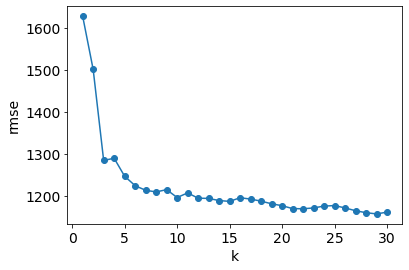

In [ ]:
kvalues = np.arange(1,31) # Parameter range

val_rmse=[]

for k in kvalues:
  knn_reg = KNeighborsRegressor(n_neighbors=k)
  knn_reg.fit(X_train, y_train)
  y_pred = knn_reg.predict(X_val)
  val_rmse.append(rmse(y_val, y_pred))

### Rmse vs k
plt.plot(kvalues,val_rmse,marker='o')
plt.xlabel("k")
plt.ylabel("rmse")
print("The minimum rmse is obtained at k = " + str(np.argmin(val_rmse)+1))

In [ ]:
knn_reg_best = KNeighborsClassifier(n_neighbors=29)
knn_reg_best.fit(X_train, y_train)
print('RMSE validation set:', round(rmse(y_val, knn_reg_best.predict(X_val)), 2))

RMSE validation set: 2646.67


And then we repeat a similar grid search from the classification case:

In [ ]:
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1,31)} # Parameter range

# defining parameter range
grid = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=False, verbose=1)
grid_search = grid.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'n_neighbors': 16}

You can visualize the crossvalidation accuracy obtained during the cross validation performed in the previous step.

The maximum performance is obtained at k = 16


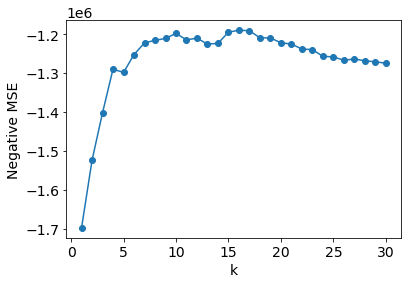

In [ ]:
plt.plot(param_grid['n_neighbors'], grid_search.cv_results_['mean_test_score'], marker='o')
plt.xlabel("k")
plt.ylabel("Negative MSE")
print("The maximum performance is obtained at k = " + str(np.argmax(grid_search.cv_results_['mean_test_score'])+1))

And similarly find the resulting performance on the validation set:

In [ ]:
knn_reg_best = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_reg_best.fit(X_train, y_train)
print('RMSE validation set:', round(rmse(y_val, knn_reg_best.predict(X_val)), 2))

RMSE validation set: 2392.01
